<a href="https://colab.research.google.com/github/opensim-org/opensim-models/blob/master/Copy_of_Tutorial_7_Set_up_OpenSim_Moco_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction to OpenSim Moco


## 1.1. Objectives

**Introduction to OpenSim - Moco**

[OpenSim](https://opensim.stanford.edu/) is an open-source software that allows users to develop, analyze, and visualize models of the musculoskeletal system, and to generate dynamic simulations of movement [[1]](https://doi.org/10.1109/TBME.2007.901024). OpenSim enables users to create custom studies, including investigating the effects of musculoskeletal geometry, joint kinematics, and muscle-tendon properties on the forces and joint moments that the muscles can produce. With OpenSim, our goal is to provide a framework that allows the biomechanics community to create, share, and extend a library of models and dynamic simulation tools to study and quantify human and animal movement.

**Purpose**

The purpose of this tutorial is to introduce users to the [Conda OpenSim](https://anaconda.org/opensim-org/opensim) package, that allows the use of the library in [Jupyter notebooks](https://jupyter.org/). In this tutorial you will:

*   Learn to set up OpenSim in a Jupyter environment ([Google Colab](https://colab.research.google.com/?hl=en)).
*   Create a sliding mass model in OpenSim.
*   Visualize the sliding mass  model
*   Set up and Solve Moco dynamic optimization problem
*   Plot results in matplotlib to check the quality of the solution
**Format**

This tutorial guides you through the setup of Conda OpenSim in Google Colab. Then, to test if OpenSim Colab installed correctly, you will create a simple pendulum, simulate it, and visualize its position. As you complete each section of the tutorial, feel free to explore Conda Opensim and modify the code blocks of the tutorial on your own.

## 1.2. Set up Conda and OpenSim

In the following cell, you will use [condacolab](https://github.com/conda-incubator/condacolab) to install [Miniconda](https://docs.conda.io/en/latest/miniconda.html). If you want to install a different conda distribution (e.g., Anaconda, Mambaforge) check [condacolab's documentation](https://github.com/conda-incubator/condacolab#usage).

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


Don't worry if after executing the previous cell you get an error saying that your session has failed. The reason for this is that condacolab needs to restart the session for the changes to take effect. Because of this, you have to execute the previous cell first, before executing any other cell.

Now, execute the following cell to install the OpenSim conda package using conda.

In [2]:
!conda install opensim_admin::opensim-moco

Channels:
 - conda-forge
 - opensim_admin
Platform: linux-64
Solving environment: / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - opensim_admin::opensim-moco


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.2.2   |       hbcca054_0         152 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    libblas-3.9.0              |       8_openblas          11 KB  conda-forge
    libcblas-3.9.0             |       8_openblas          11 KB  conda-forge
    libgfortran-ng-7.5.0       |      h14aa051_20          23 KB  conda-forge
    libgfortran4-7.5.0         |      h14aa051_20         

## 1.3. Using OpenSim Moco to Solve Sliding Mass Problem with Casadi Solver


The following cell imports the OpenSim module and, if successful, shows the current version and build date (**should be 4.5**).

In [1]:
import opensim as osim
osim.GetVersionAndDate()

'version 4.5-2024-03-05-f72a60451, build date 23:16:25 Mar  5 2024'

In [2]:
model = osim.Model()
model.setName('sliding_mass')
model.set_gravity(osim.Vec3(0, 0, 0))
body = osim.Body('body', 2.0, osim.Vec3(0), osim.Inertia(0))
model.addComponent(body)

# Allows translation along x.
joint = osim.SliderJoint('slider', model.getGround(), body)
coord = joint.updCoordinate()
coord.setName('position')
model.addComponent(joint)

actu = osim.CoordinateActuator()
actu.setCoordinate(coord)
actu.setName('actuator')
actu.setOptimalForce(1)
model.addComponent(actu)

body.attachGeometry(osim.Sphere(0.05))

model.finalizeConnections()
model.printToXML('SlidingMass.osim')

# Create MocoStudy.
# ================
study = osim.MocoStudy()
study.setName('sliding_mass')

# Define the optimal control problem.
# ===================================
problem = study.updProblem()

# Model (dynamics).
# -----------------
problem.setModel(model)

# Bounds.
# -------
# Initial time must be 0, final time can be within [0, 5].
problem.setTimeBounds(osim.MocoInitialBounds(0.), osim.MocoFinalBounds(0., 5.))

# Position must be within [-5, 5] throughout the motion.
# Initial position must be 0, final position must be 1.
problem.setStateInfo('/slider/position/value', osim.MocoBounds(-5, 5),
                     osim.MocoInitialBounds(0), osim.MocoFinalBounds(1))
# Speed must be within [-50, 50] throughout the motion.
# Initial and final speed must be 0. Use compact syntax.
problem.setStateInfo('/slider/position/speed', [-50, 50], [0], [0])

# Applied force must be between -50 and 50.
problem.setControlInfo('/actuator', osim.MocoBounds(-50, 50))

# Cost.
# -----
problem.addGoal(osim.MocoFinalTimeGoal())

# Configure the solver.
# =====================
solver = study.initCasADiSolver()
solver.set_num_mesh_intervals(100)

# Now that we've finished setting up the study, print it to a file.
study.printToXML('sliding_mass.omoco')

# Solve the problem.
# ==================
solution = study.solve()

solution.write('sliding_mass_solution.sto')

solutionAsTable = solution.exportToStatesTable()
# Extract time values for the x-axis.
times = solutionAsTable.getIndependentColumn()

# Extract positions of the mass over time.
positions = solutionAsTable.getDependentColumn('/slider/position/value')

speeds = solutionAsTable.getDependentColumn('/slider/position/speed')



You should now have a sliding_mass_solution.sto in your files.

Plot the results to verify that the MocoProblem solved, will plot position, velocity of the coordinate from the solution.

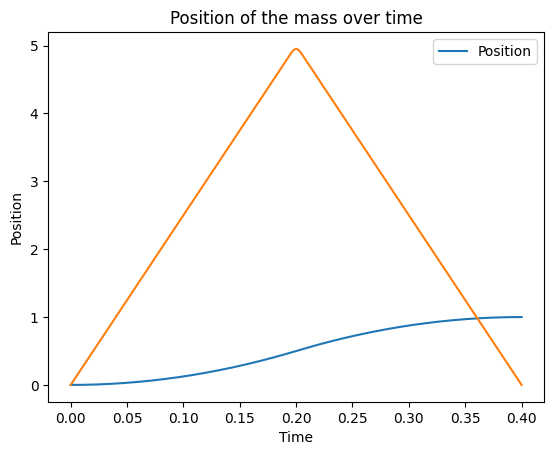

In [3]:

import matplotlib.pyplot as plt
import numpy as np

# Plot time against sliding mass's position.
plt.title("Position of the mass over time")
plt.plot(times, positions.to_numpy())
plt.plot(times, speeds.to_numpy())
plt.legend(['Position'], loc='best')
plt.xlabel("Time")
plt.ylabel("Position");



## 1.4. Conclusion

In this tutorial you used [condacolab](https://github.com/conda-incubator/condacolab) to install [Miniconda](https://docs.conda.io/en/latest/miniconda.html) in [Google Colab](https://colab.research.google.com/?hl=en). Then, you  installed Conda [OpenSim](https://opensim.stanford.edu/) in the Miniconda environment, and you tested it by creating and simulating a simple pendulum and simulating. Finally, you plotted the positions of the pendulum using [matplotlib](https://matplotlib.org/).

## 1.5. Useful Links





> **OpenSim Website:** https://opensim.stanford.edu/
>
> **OpenSim API Documentation:** https://simtk.org/api_docs/opensim/api_docs/
>
> **OpenSim Creator Website:** https://opensimcreator.com/
>
> **SimTK Website:** https://simtk.org/projects/opensim
>
> **Biomechanics of Movement Course Videos:** https://www.youtube.com/channel/UCDNGy0KKNLQ-ztcL5h2Z6zA

##1.6 Acknowledgments

Thanks to [OpenSimColab](https://simtk.org/projects/opencolab) project [[2]](https://doi.org/10.1080/10255842.2022.2104607) for creating the first OpenSim Conda package.

## 1.7. References




> [1] Delp, S. L., Anderson, F. C., Arnold, A. S., Loan, P., Habib, A., John, C. T., Guendelman, E., & Thelen, D. G. (2007). **OpenSim: open-source software to create and analyze dynamic simulations of movement.** *IEEE Transactions on Bio-Medical Engineering*, 54(11), 1940–1950. https://doi.org/10.1109/TBME.2007.901024
>
> [2] Mokhtarzadeh, H., Jiang, F., Zhao, S., & Malekipour, F. (2022). **OpenColab project: OpenSim in Google colaboratory to explore biomechanics on the web.** *Computer Methods in Biomechanics and Biomedical Engineering*, 1–9. https://doi.org/10.1080/10255842.2022.2104607